/Users/olegpolakow/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: UserWarning:

Data contains NaNs. Use `fillna` argument or `show` method in case of visualization issues.



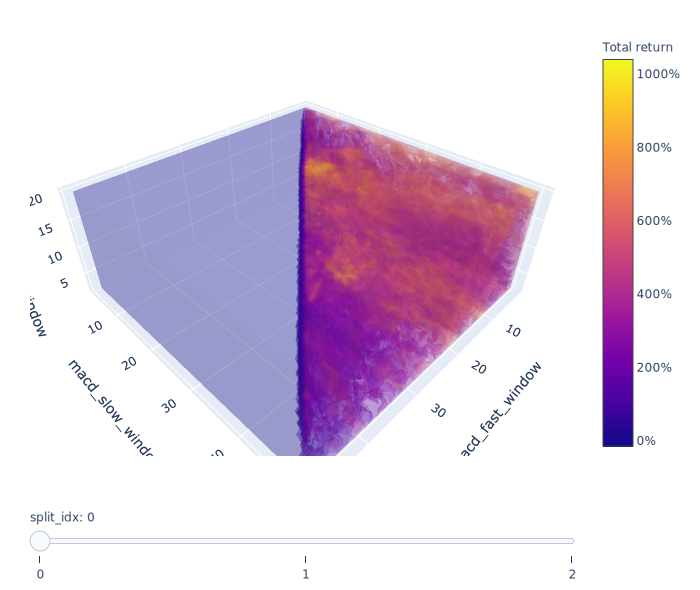

In [1]:
import vectorbt as vbt
import numpy as np
from itertools import combinations, product

# Fetch daily price of Bitcoin
price = vbt.YFData.download("BTC-USD", start='2017-01-01 UTC').get('Close')
price, _ = price.vbt.range_split(n=3)

# Define hyper-parameter space
# 49 fast x 49 slow x 19 signal
fast_windows, slow_windows, signal_windows = vbt.utils.params.create_param_combs(
    (product, (combinations, np.arange(2, 51, 1), 2), np.arange(2, 21, 1)))

# Run MACD indicator
macd_ind = vbt.MACD.run(
    price,
    fast_window=fast_windows,
    slow_window=slow_windows,
    signal_window=signal_windows
)

# Long when MACD is above zero AND signal
entries = macd_ind.macd_above(0) & macd_ind.macd_above(macd_ind.signal)

# Short when MACD is below zero OR signal
exits = macd_ind.macd_below(0) | macd_ind.macd_below(macd_ind.signal)

# Build portfolio
pf = vbt.Portfolio.from_signals(
    price.vbt.tile(len(fast_windows)), entries, exits, fees=0.001, freq='1D')

# Draw all window combinations as a 3D volume
fig = pf.total_return().vbt.volume(
    x_level='macd_fast_window',
    y_level='macd_slow_window',
    z_level='macd_signal_window',
    slider_level='split_idx',
    trace_kwargs=dict(
        colorbar=dict(
            title='Total return', 
            tickformat='%'
        )
    )
)
fig.show()